In [ ]:
!pip install --upgrade lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('BNB2019-2024.csv')
data1=data.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(data1))
test_size = int(0.3 * len(data1))

train_data = data1[:train_size]
test_data = data1[train_size:train_size+test_size]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 15s 308ms/step - loss: 0.0564
Epoch 2/100
19/19 [==============================] - 4s 181ms/step - loss: 0.0091
Epoch 3/100
19/19 [==============================] - 4s 217ms/step - loss: 0.0048
Epoch 4/100
19/19 [==============================] - 3s 137ms/step - loss: 0.0039
Epoch 5/100
19/19 [==============================] - 3s 137ms/step - loss: 0.0036
Epoch 6/100
19/19 [==============================] - 3s 137ms/step - loss: 0.0034
Epoch 7/100
19/19 [==============================] - 3s 151ms/step - loss: 0.0030
Epoch 8/100
19/19 [==============================] - 4s 208ms/step - loss: 0.0028
Epoch 9/100
19/19 [==============================] - 3s 136ms/step - loss: 0.0030
Epoch 10/100
19/19 [==============================] - 3s 140ms/step - loss: 0.0025
Epoch 11/100
19/19 [==============================] - 3s 136ms/step - loss: 0.0025
Epoch 12/100
19/19 [==============================] - 3s 179ms/step - loss: 0.0027
Epoch 13/100

In [ ]:
# Trích xuất đặc trưng bằng mô hình LSTM
feature_extractor = Sequential()
feature_extractor.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
features_train = feature_extractor.predict(X_train)
features_test = feature_extractor.predict(X_test)

14/14 [==============================] - 0s 10ms/step


In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

14/14 [==============================] - 0s 31ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [ ]:
# Chuẩn bị dữ liệu cho LightGBM
lgb_train = lgb.Dataset(features_train, label=y_train)
lgb_test = lgb.Dataset(features_test, label=ytest, reference=lgb_train)

params = {
    'objective': 'regression',  # Thay đổi nếu là bài toán phân loại
    'metric': 'rmse',  # Thay đổi nếu muốn sử dụng các metric khác
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Huấn luyện mô hình LightGBM
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6639
[LightGBM] [Info] Number of data points in the train set: 1169, number of used features: 37
[LightGBM] [Info] Start training from score 0.283281


In [ ]:
# Dự đoán và đánh giá
y_pred_scaled = gbm.predict(features_test, num_iteration=gbm.best_iteration)


In [ ]:
# Đưa kết quả dự đoán và thực tế về dạng gốc
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
# Tính toán các chỉ số RMSE, MAPE, MSE
rmse = mean_squared_error(y_test_orig, y_pred, squared=False)
mse = mean_squared_error(y_test_orig, y_pred)
mape = mean_absolute_percentage_error(y_test_orig, y_pred)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAPE:", mape)

RMSE: 12.701855733246258
MSE: 161.33713906820083
MAPE: 0.037913631777043086


In [ ]:
def predict_future(model, data, steps, time_step):
    temp_input = list(data[-time_step:].flatten())

    lst_output = []
    i = 0
    while(i < steps):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat.flatten().tolist())
            lst_output.extend(yhat.flatten().tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat.flatten().tolist())
            lst_output.extend(yhat.flatten().tolist())
            i += 1
    return lst_output

# Dự báo 30, 60, 90 ngày tiếp theo
pred_30_days = predict_future(feature_extractor, features_test, 30, time_step)
pred_60_days = predict_future(feature_extractor, features_test, 60, time_step)
pred_90_days = predict_future(feature_extractor, features_test, 90, time_step)

# Đưa dự báo về dạng gốc
pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


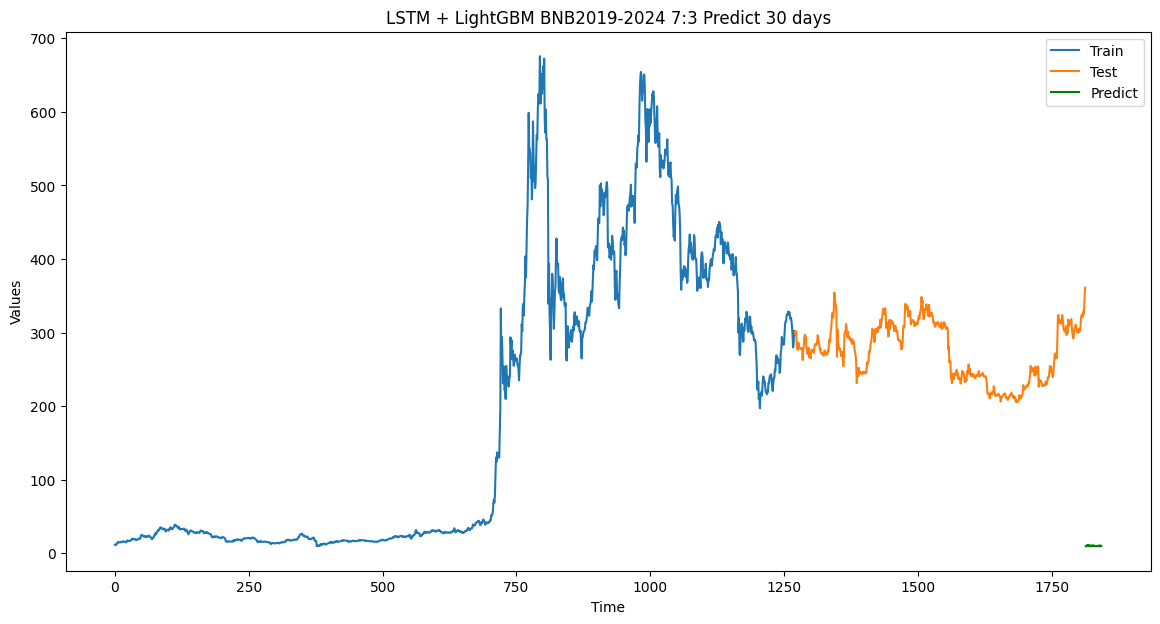

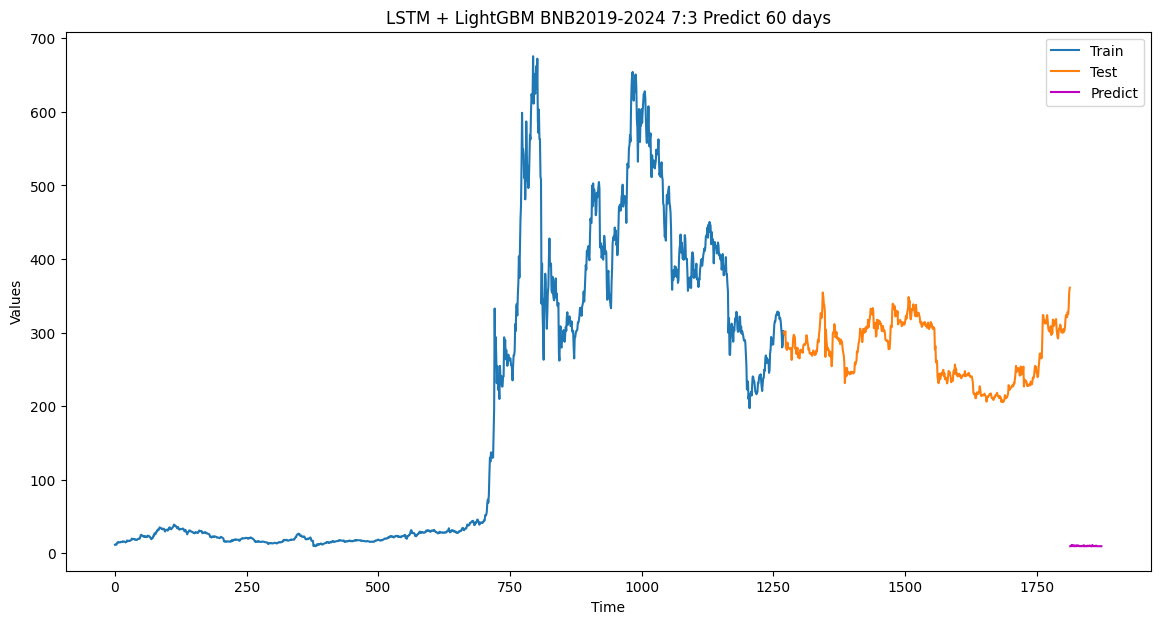

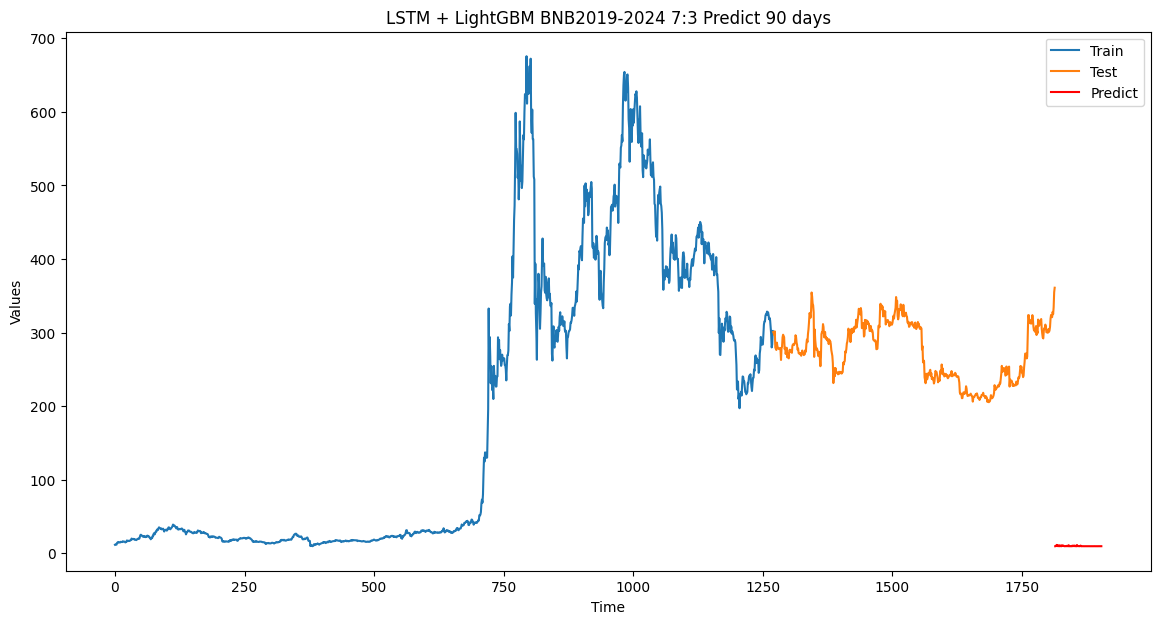

In [44]:
def plot_predictions(pred, steps, title, color):
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')

    # Lấy phần dữ liệu dự đoán có kích thước khớp với steps
    pred_range = range(len(train_data) + len(test_data), len(train_data) + len(test_data) + steps)

    plt.plot(pred_range[:steps], pred[:steps], label='Predict', color=color)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

# Vẽ biểu đồ dự đoán 30, 60, 90 ngày
plot_predictions(pred_30_days, 30, 'LSTM + LightGBM BNB2019-2024 7:3 Predict 30 days', 'g')
plot_predictions(pred_60_days, 60, 'LSTM + LightGBM BNB2019-2024 7:3 Predict 60 days', 'm')
plot_predictions(pred_90_days, 90, 'LSTM + LightGBM BNB2019-2024 7:3 Predict 90 days', 'r')
